In [1]:
! git clone 'https://github.com/PeterF1234/DFT-ML-excited-state-redox/' # if using Google Colab

Cloning into 'DFT-ML-excited-state-redox'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 23 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (23/23), 1.91 MiB | 7.18 MiB/s, done.


## Import libraries

In [1]:
# !pip install matplotlib --upgrade # 1) uncomment, 2) run, 3) restart kernel, 4) comment out, 5) run all

In [2]:
import matplotlib as matp
matp.__version__ # correlation plots require 3.5+

'3.7.1'

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_absolute_error
from scipy.stats import pearsonr

In [4]:
pd.__version__

'1.3.5'

## Set up the databases

In [6]:
# read in the data for the redox potentials
gs_redox_potentials = pd.read_csv("/content/DFT-ML-excited-state-redox/redox_potentials_raw_2023_02.csv", header=0)
expt_es_redox_potentials = pd.read_csv("/content/DFT-ML-excited-state-redox/expt_excited_potentials_refiltered.csv", header=0)

In [7]:
rename_dict = {'wPBEPP86':'$\\omega$-PBEPP86', 'B2GPPLYP':'B2GP-PLYP', 'RI-SCS-PBE-QIDH':'SCS-PBE-QIDH', 
               'RI-B2PLYP':'B2PLYP', 'RI-wB2PLYP':'$\\omega$-B2PLYP', 'B3LYP-D3':'B3LYP', 
               'CAM-B3LYP-D3':'CAM-B3LYP', 'PBE-D3':'PBE', 'wB97XD':'$\\omega$-B97XD'}
gs_redox_potentials.replace(rename_dict, inplace=True)

func_order = ['$\\omega$-PBEPP86', '$\\omega$-B2PLYP', 'B2PLYP', 'B2GP-PLYP', 'SCS-PBE-QIDH', 'DSD-BLYP',
              '$\\omega$-B97XD', 'CAM-B3LYP', 'B3LYP', 'M06', 'M062X',
              'M06L', 'TPSS', 'B97D3', 'PBE', 'TDHF', 'experiment']
func_order_DFTonly = func_order[:-2]

gs_redox_potentials['functional'] = pd.Categorical(gs_redox_potentials['functional'],categories=func_order,ordered=True)
gs_redox_potentials = gs_redox_potentials.sort_values(['functional'], ignore_index=True)

the code below is used to generate the `experimental_potentials.csv` file but we do not need it now as it is included in the GitHub repository

In [8]:
# gs_redox_potentials.query("functional == 'experiment'").sort_values(by="molecule").drop(columns=["functional"]).merge(expt_es_redox_potentials).to_csv("experimental_potentials.csv", index=False)

In [9]:
# convert the redox database to long format for easier analysis
gs_redox_potentials.rename(columns={"oxidation_potential": "E(M+/M)", "reduction_potential": "E(M/M-)"}, inplace=True)
gs_redox_potentials_long = pd.melt(gs_redox_potentials, 
                                   id_vars=["molecule","functional"],
                                   value_vars=gs_redox_potentials.columns[2:], # fist two columns are 'molecule', 'functional', rest are the potentials
                                   var_name="potential_type",
                                   value_name="potential_value")
longpots_pred = gs_redox_potentials_long.query("functional != 'experiment'").copy()
longpots_pred = longpots_pred.rename(columns={"potential_value":"predicted_value"})
longpots_expt = gs_redox_potentials_long.query("functional == 'experiment'").copy()
longpots_expt = longpots_expt.rename(columns={"potential_value":"actual_value"}).drop(columns=["functional"])
longpots = longpots_pred.merge(longpots_expt)
len(longpots.functional.unique())

16

There are 16 "functionals" so we can make a 4x4 plot or drop the Hartree-Fock to get a 3x5 plot arrangement.

In [10]:
longpots_to_plot = longpots.query("functional != 'TDHF'").dropna() # dropna() removes lines with no expt data
longpots_to_plot["delta"] = abs(longpots_to_plot["actual_value"] - longpots_to_plot["predicted_value"])
longpots_to_plot['functional'] = pd.Categorical(longpots_to_plot['functional'],categories=func_order_DFTonly,ordered=True)
longpots_to_plot = longpots_to_plot.sort_values(['functional'], ignore_index=True)

In [11]:
longpots_to_plot.describe() # print min/max values to get xlim and ylim

,predicted_value,actual_value,delta
count,855.000000,855.000000,855.000000
mean,-0.089808,0.198403,0.439908
std,1.368691,1.131044,0.315390
min,-2.786868,-1.760000,0.001841
25%,-1.169686,-0.830000,0.202025
50%,-0.081882,0.390000,0.377809
75%,0.954857,1.300000,0.601465
max,2.923084,1.880000,1.706868


Adjust the calculated potentials using the corresponding organic solvent vs water junction potential. The equations and the junction potential values for ACN and DMF can be found in the [paper of Isse and Gennaro](https://doi.org/10.1021/jp100402x). The DCM values are not corrected due to the lack of literature data and the assumption that for organic solvents the [junction potentials get larger as the dipole moment relative to water increases](https://doi.org/10.1071/CH9741617). Water has a dipole moment of [1.87 D](https://people.chem.umass.edu/xray/solvent.html), whereas DCM has a dipole moment of [1.14 D](https://people.chem.umass.edu/xray/solvent.html) which is considerably lower than the [3.44 and 3.86 D](https://people.chem.umass.edu/xray/solvent.html) values for ACN and DMF.

In [12]:
all_mols = longpots_to_plot.molecule.unique()
ACN_mols = ["Mes-Acr_1", "Rh_B", "Rh_6G"] + [i for i in all_mols if "Ph-Acr" in i or "CA" in i or "Eos" in i or "NCE" in i]
DCM_mols = [i for i in all_mols if "BOH-Acr" in i or "BF3-Acr" in i or "PDI" in i]
DMF_mols = [i for i in all_mols if "Me2-Acr" in i or "PA_" in i or "POZ" in i or "PTZ" in i]
# len(all_mols) == len(ACN_mols+DCM_mols+DMF_mols) # test passed
ACN_mols_ = dict(zip(ACN_mols, len(ACN_mols)*["ACN"]))
DCM_mols_ = dict(zip(DCM_mols, len(DCM_mols)*["DCM"]))
DMF_mols_ = dict(zip(DMF_mols, len(DMF_mols)*["DMF"]))
mols_solv_pairs = {**ACN_mols_, **DCM_mols_, **DMF_mols_}

In [13]:
# longpots_withsolv = longpots_to_plot.copy()
# longpots_withsolv["solvent"] = longpots_withsolv["molecule"]
# longpots_withsolv.replace({"solvent" : mols_solv_pairs}, inplace=True)

# longpots_withsolv.loc[longpots_withsolv['solvent'] == "ACN", 'predicted_value'] += 0.093
# longpots_withsolv.loc[longpots_withsolv['solvent'] == "DMF", 'predicted_value'] += 0.172
# longpots_withsolv["delta"] = abs(longpots_withsolv["actual_value"] - longpots_withsolv["predicted_value"])
# longpots_withsolv

In [14]:
longpots_to_plot["solvent"] = longpots_to_plot["molecule"]
longpots_to_plot.replace({"solvent" : mols_solv_pairs}, inplace=True)

longpots_to_plot.loc[longpots_to_plot['solvent'] == "ACN", 'predicted_value'] += 0.093
longpots_to_plot.loc[longpots_to_plot['solvent'] == "DMF", 'predicted_value'] += 0.172
longpots_to_plot["delta"] = abs(longpots_to_plot["actual_value"] - longpots_to_plot["predicted_value"])
longpots_to_plot

,molecule,functional,potential_type,predicted_value,actual_value,delta,solvent
0,NCE_3,$\omega$-PBEPP86,E(M+/M),2.291910,1.64,0.651910,ACN
1,Rh_B,$\omega$-PBEPP86,E(M/M-),-1.096552,-0.87,0.226552,ACN
2,NCE_2,$\omega$-PBEPP86,E(M/M-),-1.974766,-1.76,0.214766,ACN
3,PA_2,$\omega$-PBEPP86,E(M+/M),0.390875,0.23,0.160875,DMF
4,Eos_3,$\omega$-PBEPP86,E(M+/M),2.019294,0.48,1.539294,ACN
...,...,...,...,...,...,...,...
850,NCE_3,PBE,E(M/M-),-1.600434,-1.70,0.099566,ACN
851,Me2-Acr_3,PBE,E(M+/M),0.537086,0.90,0.362914,DMF
852,Ph-Acr_1,PBE,E(M/M-),-1.191532,-0.83,0.361532,ACN
853,Eos_1,PBE,E(M+/M),-0.105415,0.39,0.495415,ACN


Plot the results:

- uncomment the lines with `plt.savefig` to obtain high-res images 

<ipython-input-15-1f3789439b85>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-paper")


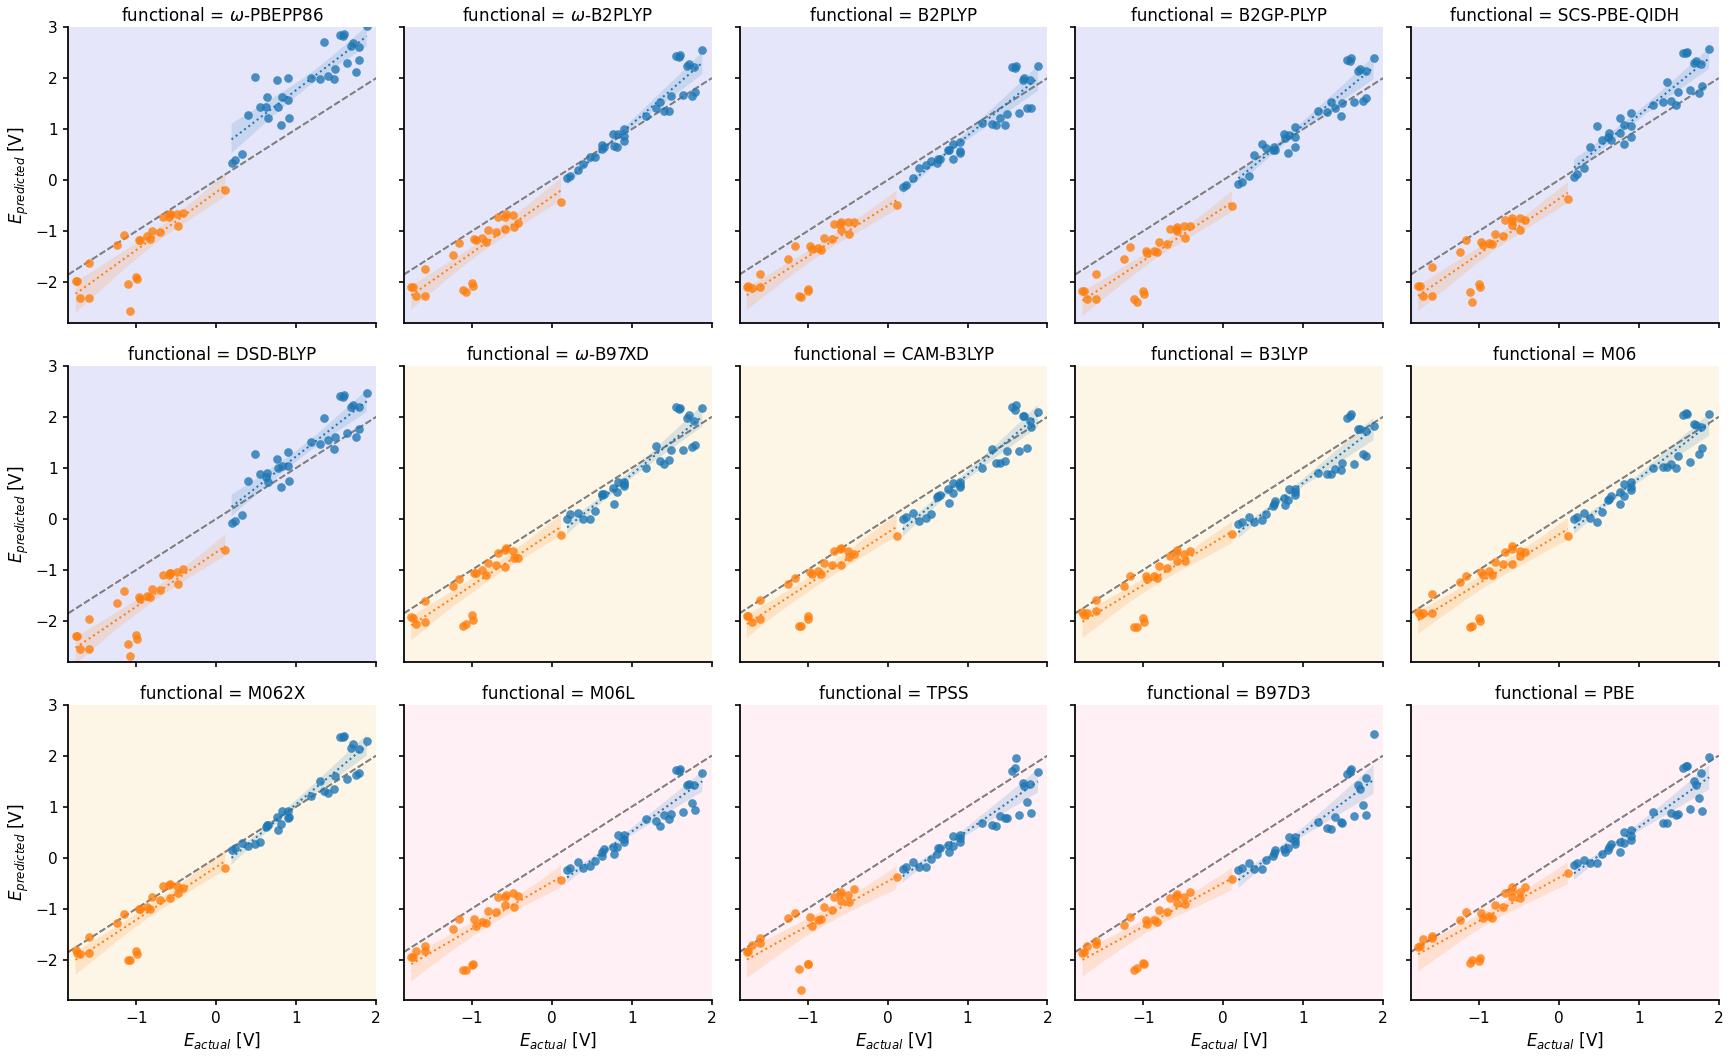

In [15]:
sns.reset_orig()
plt.style.use("seaborn-paper")
sns.set_context("paper", font_scale=1.75, rc={"lines.linewidth": 1.75,"axes.linewidth": 1.75,'xtick.major.width': 1.6,'ytick.major.width': 1.6})

# store underlying facet grid
g = sns.lmplot(x="actual_value", y="predicted_value", col='functional', hue='potential_type', 
               col_wrap=5, data=longpots_to_plot, aspect=0.9,
               scatter_kws={"s": 75}, line_kws={"lw": 2,"ls": ":"})

g.map_dataframe(lambda data, **kws: plt.axline((0,0), slope=1., c="grey", ls='--', zorder=0)) # x=y line, this requires the latest version of matplotlib
g.set(xlabel=(r'$E_{actual}$ [V]'),ylabel=(r'$E_{predicted}$ [V]'))
g._legend.remove()

for N, i in enumerate(g.axes.flat):
  if N < 6: # double hybrids
    i.set_facecolor("lavender")
  if N >= 6 and N < 11: # hybrids
    i.set_facecolor("oldlace")
  if N >= 11: # pure functionals
    i.set_facecolor("lavenderblush")

sns.despine()
plt.xlim(-1.85,2.0)
plt.ylim(-2.8,3.)
plt.tight_layout()
# plt.savefig('gs_redox_raw.png', dpi=200, bbox_inches='tight', pad_inches=0)
plt.show()
plt.close()

<ipython-input-16-0f74594a7fd5>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-paper")


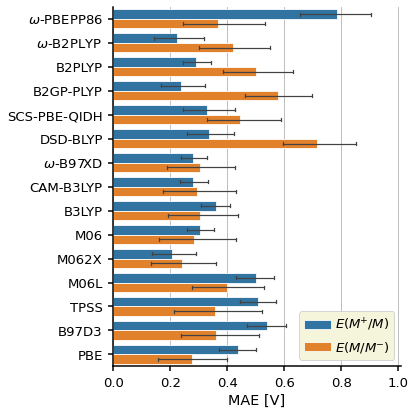

In [16]:
sns.reset_orig()
plt.style.use("seaborn-paper")
scale=1.5
sns.set_context("paper", font_scale=scale, rc={"lines.linewidth": scale,"axes.linewidth": 
                                               scale,'xtick.major.width': scale,'ytick.major.width': scale})

plt.figure(figsize=(6,6))
ax = sns.barplot(data=longpots_to_plot.replace({"E(M+/M)":r'$E(M\! ^+\! / M)$', "E(M/M-)":r'$E(M/ M\! ^-\!)$'}),
                 x="delta", y="functional", hue="potential_type", edgecolor="white", errwidth=1.2, capsize=.125)
ax.set(xlabel=r'MAE [V]', ylabel=None)

ax.legend(frameon=True, title=None, loc='best', facecolor="beige", framealpha=1, #bbox_to_anchor=(0.5, 1.04), 
          ncols=1, handletextpad=0.3)

ax.grid(axis = 'x')
ax.set_axisbelow(True)
sns.despine()
plt.xlim(0,1.01)
plt.tight_layout()
# plt.savefig('gs_redox_raw_MAE.png', dpi=200, bbox_inches='tight', pad_inches=0.05)
plt.show()
plt.close()

Print some statistics for the raw DFT results:

In [17]:
longpots_to_plot.delta.mean()

0.3815471661578215

In [18]:
longpots_to_plot.query("potential_type == 'E(M+/M)'").groupby("functional", as_index=False).mean()

,functional,predicted_value,actual_value,delta
0,$\omega$-PBEPP86,1.882101,1.096563,0.785539
1,$\omega$-B2PLYP,1.231921,1.096563,0.222223
2,B2PLYP,0.994410,1.096563,0.290189
3,B2GP-PLYP,1.199571,1.096563,0.237050
4,SCS-PBE-QIDH,1.394791,1.096563,0.330218
5,DSD-BLYP,1.345570,1.096563,0.336649
6,$\omega$-B97XD,0.998798,1.096563,0.280663
7,CAM-B3LYP,0.993348,1.096563,0.281726
8,B3LYP,0.823288,1.096563,0.361980
9,M06,0.909459,1.096562,0.306324


In [19]:
longpots_to_plot.query("potential_type == 'E(M/M-)'").groupby("functional", as_index=False).mean()

,functional,predicted_value,actual_value,delta
0,$\omega$-PBEPP86,-1.313594,-0.951242,0.368982
1,$\omega$-B2PLYP,-1.371087,-0.951242,0.419845
2,B2PLYP,-1.451965,-0.951242,0.500723
3,B2GP-PLYP,-1.528558,-0.951242,0.577316
4,SCS-PBE-QIDH,-1.396233,-0.951242,0.444991
5,DSD-BLYP,-1.667137,-0.951242,0.715894
6,$\omega$-B97XD,-1.254305,-0.951242,0.304406
7,CAM-B3LYP,-1.239327,-0.951242,0.292933
8,B3LYP,-1.252880,-0.951242,0.304585
9,M06,-1.216911,-0.951242,0.283832


## Apply a shift to the potentials

In [20]:
def optimize_predictions(df_, scales, shifts, silent=False):
  functionals = df_.functional.unique()
  potentials = df_.potential_type.unique()
  sub_dfs = []
  opt_params_ = []
  for fnc in functionals:
    for pot in potentials:
      min_mean_delta = 1e6
      for scale in scales:
        for shift in shifts:
          sub_df = df_.query("functional == @fnc and potential_type == @pot").copy()
          sub_df["modified_value"] = scale * sub_df["predicted_value"] + shift
          sub_df["modified_delta"] = abs(sub_df["modified_value"] - sub_df["actual_value"])
          mean_delta = sub_df["modified_delta"].mean()
          if mean_delta < min_mean_delta:
            min_mean_delta = mean_delta
            opt_scale = scale
            opt_shift = shift
      if silent == False:
        print(f"optimal scale and shift for {fnc} and {pot}: {opt_scale}, {opt_shift}")
      opt_params_.append(pd.DataFrame({"functional": [f"{fnc}"], "potential_type": [f"{pot}"], "scale": [opt_scale], "shift": [opt_shift]}))
      sub_df = df_.query("functional == @fnc and potential_type == @pot").copy()
      sub_df["modified_value"] = opt_scale * sub_df["predicted_value"] + opt_shift
      sub_df["modified_delta"] = abs(sub_df["modified_value"] - sub_df["actual_value"])
      sub_dfs.append(sub_df)
  df_optimized = pd.concat(sub_dfs)
  opt_params = pd.concat(opt_params_, ignore_index=True)
  return df_optimized, opt_params

def optimize_predictions_no_outliers(df_, scales, shifts):
  functionals = df_.functional.unique()
  potentials = df_.potential_type.unique()
  sub_dfs = []
  opt_params_ = []
  for fnc in functionals:
    for pot in potentials:
      min_mean_delta = 1e6
      for scale in scales:
        for shift in shifts:
          sub_df = df_.query("functional == @fnc and potential_type == @pot").copy()
          # remove outliers
          dlta_std = sub_df["delta"].std()
          dlta_mean = sub_df["delta"].mean()
          # sub_df_outliers = sub_df.query("delta > (@dlta_mean + (@dlta_std * 2)) or delta < (@dlta_mean - (@dlta_std * 2))")
          sub_df_inliers = sub_df.query("delta < (@dlta_mean + (@dlta_std * 2)) and delta > (@dlta_mean - (@dlta_std * 2))").copy()
          sub_df_inliers["modified_value"] = scale * sub_df_inliers["predicted_value"] + shift
          sub_df_inliers["modified_delta"] = abs(sub_df_inliers["modified_value"] - sub_df_inliers["actual_value"])
          mean_delta = sub_df_inliers["modified_delta"].mean()
          if mean_delta < min_mean_delta:
            min_mean_delta = mean_delta
            opt_scale = scale
            opt_shift = shift
      print(f"optimal scale and shift for {fnc} and {pot}: {opt_scale}, {opt_shift}")
      opt_params_.append(pd.DataFrame({"functional": [f"{fnc}"], "potential_type": [f"{pot}"], "scale": [opt_scale], "shift": [opt_shift]}))
      sub_df = df_.query("functional == @fnc and potential_type == @pot").copy()
      sub_df["modified_value"] = opt_scale * sub_df["predicted_value"] + opt_shift
      sub_df["modified_delta"] = abs(sub_df["modified_value"] - sub_df["actual_value"])
      sub_dfs.append(sub_df)
  df_optimized = pd.concat(sub_dfs)
  opt_params = pd.concat(opt_params_, ignore_index=True)
  return df_optimized, opt_params

Shift all the DFT potentials by 0.2 V:

In [21]:
%%time
scales = [1]
shifts = [0.2]
gs_FixedShift, FixedShift_params = optimize_predictions(longpots_to_plot, scales, shifts, silent=True)

CPU times: user 339 ms, sys: 6.04 ms, total: 345 ms
Wall time: 343 ms


<ipython-input-22-5ef33f4326ce>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-paper")


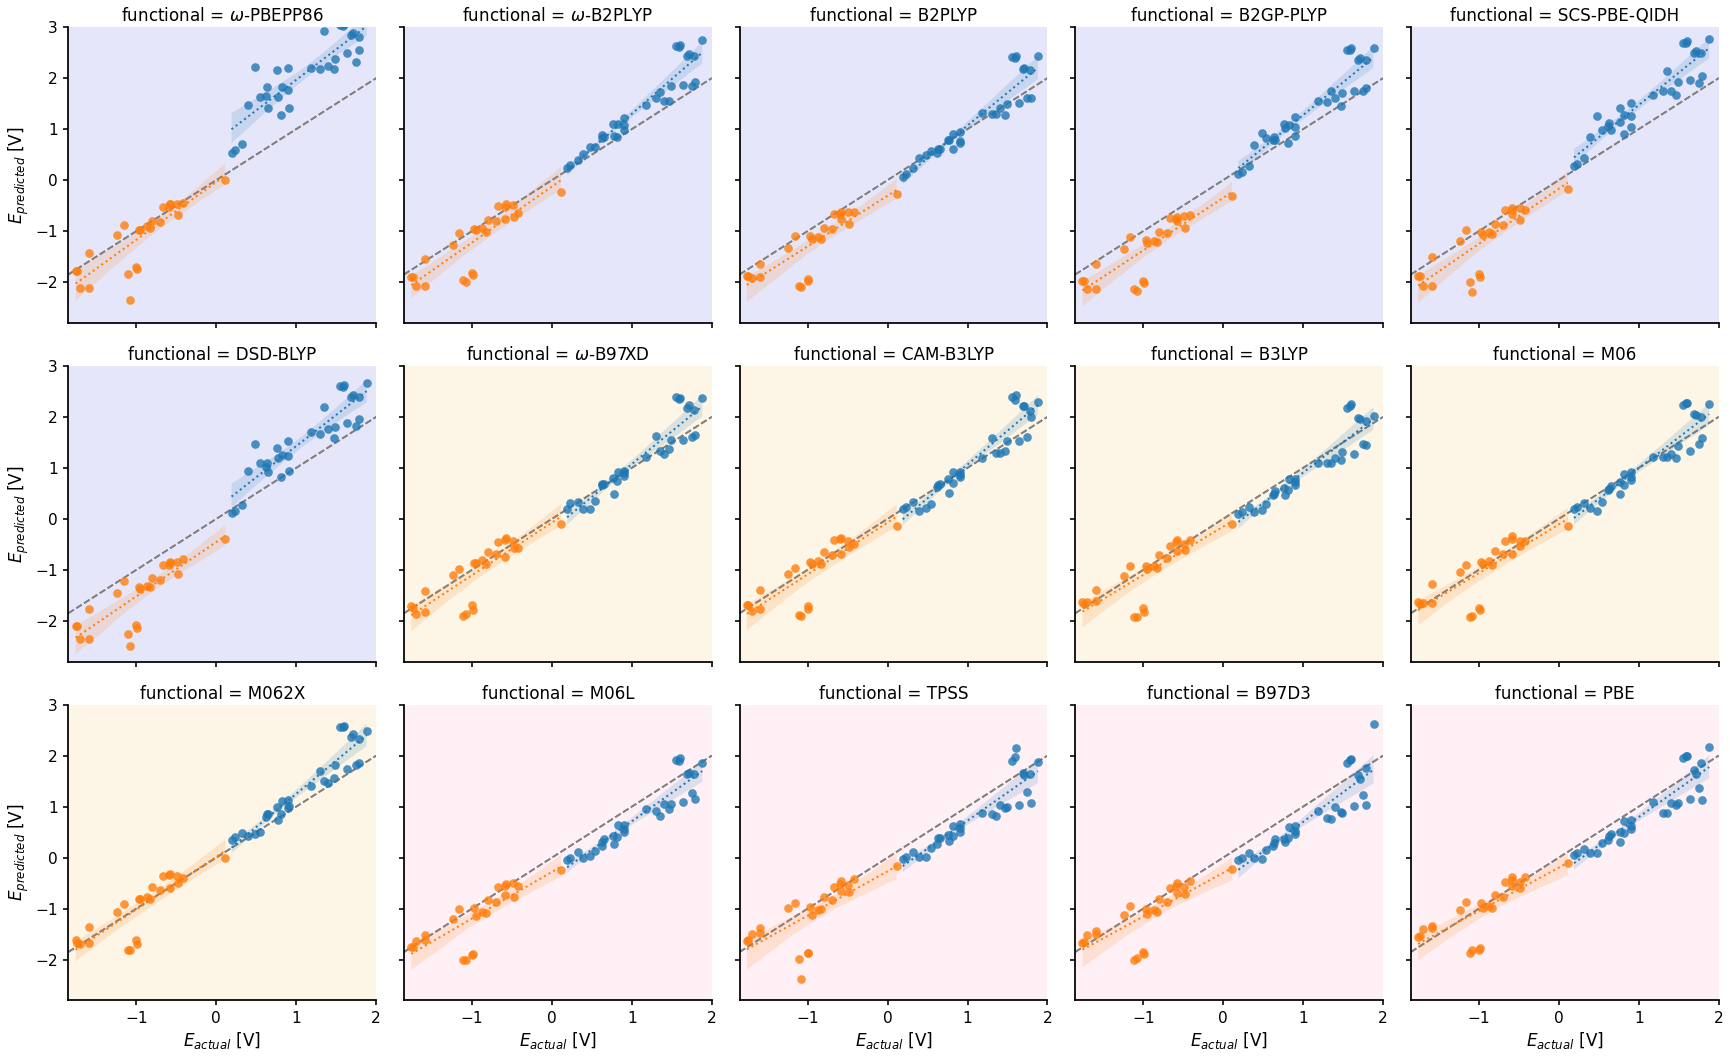

In [22]:
sns.reset_orig()
plt.style.use("seaborn-paper")
sns.set_context("paper", font_scale=1.75, rc={"lines.linewidth": 1.75,"axes.linewidth": 1.75,'xtick.major.width': 1.6,'ytick.major.width': 1.6})

# store underlying facet grid
g = sns.lmplot(x="actual_value", y="modified_value", col='functional', hue='potential_type', 
               col_wrap=5, data=gs_FixedShift, aspect=0.9, 
               scatter_kws={"s": 75}, line_kws={"lw": 2,"ls": ":"})

g.map_dataframe(lambda data, **kws: plt.axline((0,0), slope=1., c="grey", ls='--', zorder=0)) # x=y line, this requires the latest version of matplotlib
g.set(xlabel=(r'$E_{actual}$ [V]'),ylabel=(r'$E_{predicted}$ [V]'))
g._legend.remove()

for N, i in enumerate(g.axes.flat):
  if N < 6: # double hybrids
    i.set_facecolor("lavender")
  if N >= 6 and N < 11: # hybrids
    i.set_facecolor("oldlace")
  if N >= 11: # pure functionals
    i.set_facecolor("lavenderblush")

sns.despine()
plt.xlim(-1.85,2.0)
plt.ylim(-2.8,3.)
plt.tight_layout()
# plt.savefig('gs_redox_0.2V_shift.png', dpi=200, bbox_inches='tight', pad_inches=0)
plt.show()
plt.close()

<ipython-input-23-7330dca047ab>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-paper")


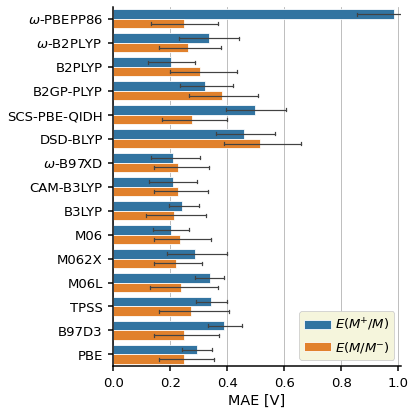

In [23]:
sns.reset_orig()
plt.style.use("seaborn-paper")
scale=1.5
sns.set_context("paper", font_scale=scale, rc={"lines.linewidth": scale,"axes.linewidth": 
                                               scale,'xtick.major.width': scale,'ytick.major.width': scale})

plt.figure(figsize=(6,6))
ax = sns.barplot(data=gs_FixedShift.replace({"E(M+/M)":r'$E(M\! ^+\! / M)$', "E(M/M-)":r'$E(M/ M\! ^-\!)$'}), 
                 x="modified_delta", y="functional", hue="potential_type", edgecolor="white", errwidth=1.2, capsize=.125)
ax.set(xlabel=r'MAE [V]', ylabel=None)
# ax.legend(frameon=True, title=None, loc='upper right', facecolor="white", framealpha=1, bbox_to_anchor=(1.01, 1.03))
# ax.legend(frameon=True, title=None, loc='center', facecolor="white", framealpha=1, ncol=2, bbox_to_anchor=(0.5, 1.04))

ax.legend(frameon=True, title=None, loc='best', facecolor="beige", framealpha=1, #bbox_to_anchor=(0.5, 1.04), 
          ncols=1, handletextpad=0.3)

ax.grid(axis = 'x')
ax.set_axisbelow(True)
sns.despine()
plt.xlim(0,1.01)
plt.tight_layout()
# plt.savefig('gs_redox_0.2V_shift_MAE.png', dpi=200, bbox_inches='tight', pad_inches=0.05)
plt.show()
plt.close()

Optimize the shifts individually for each functional/potential combination:

In [24]:
%%time
scales = [1]
shifts = np.linspace(-1.,1.,101)
gs_NoLimitShift, NoLimitShift_params = optimize_predictions(longpots_to_plot, scales, shifts, silent=False)

optimal scale and shift for $\omega$-PBEPP86 and E(M+/M): 1, -0.8200000000000001
optimal scale and shift for $\omega$-PBEPP86 and E(M/M-): 1, 0.21999999999999997
optimal scale and shift for $\omega$-B2PLYP and E(M+/M): 1, -0.020000000000000018
optimal scale and shift for $\omega$-B2PLYP and E(M/M-): 1, 0.3400000000000001
optimal scale and shift for B2PLYP and E(M+/M): 1, 0.19999999999999996
optimal scale and shift for B2PLYP and E(M/M-): 1, 0.40000000000000013
optimal scale and shift for B2GP-PLYP and E(M+/M): 1, -0.040000000000000036
optimal scale and shift for B2GP-PLYP and E(M/M-): 1, 0.45999999999999996
optimal scale and shift for SCS-PBE-QIDH and E(M+/M): 1, -0.24
optimal scale and shift for SCS-PBE-QIDH and E(M/M-): 1, 0.3400000000000001
optimal scale and shift for DSD-BLYP and E(M+/M): 1, -0.21999999999999997
optimal scale and shift for DSD-BLYP and E(M/M-): 1, 0.56
optimal scale and shift for $\omega$-B97XD and E(M+/M): 1, 0.17999999999999994
optimal scale and shift for $\omega

In [25]:
saveparams_ox = NoLimitShift_params.query("potential_type == 'E(M+/M)'").rename(columns={"shift":"E(M+/M)_shift"}).drop(columns=["potential_type","scale"]).copy()
saveparams_red = NoLimitShift_params.query("potential_type == 'E(M/M-)'").rename(columns={"shift":"E(M/M-)_shift"}).drop(columns=["potential_type","scale"]).copy()
saveparams_ = saveparams_ox.merge(saveparams_red)
# saveparams_.to_csv("optimized_shifts.csv", index=False) # uncomment to save the shifts to a file

<ipython-input-26-15c372d68360>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-paper")


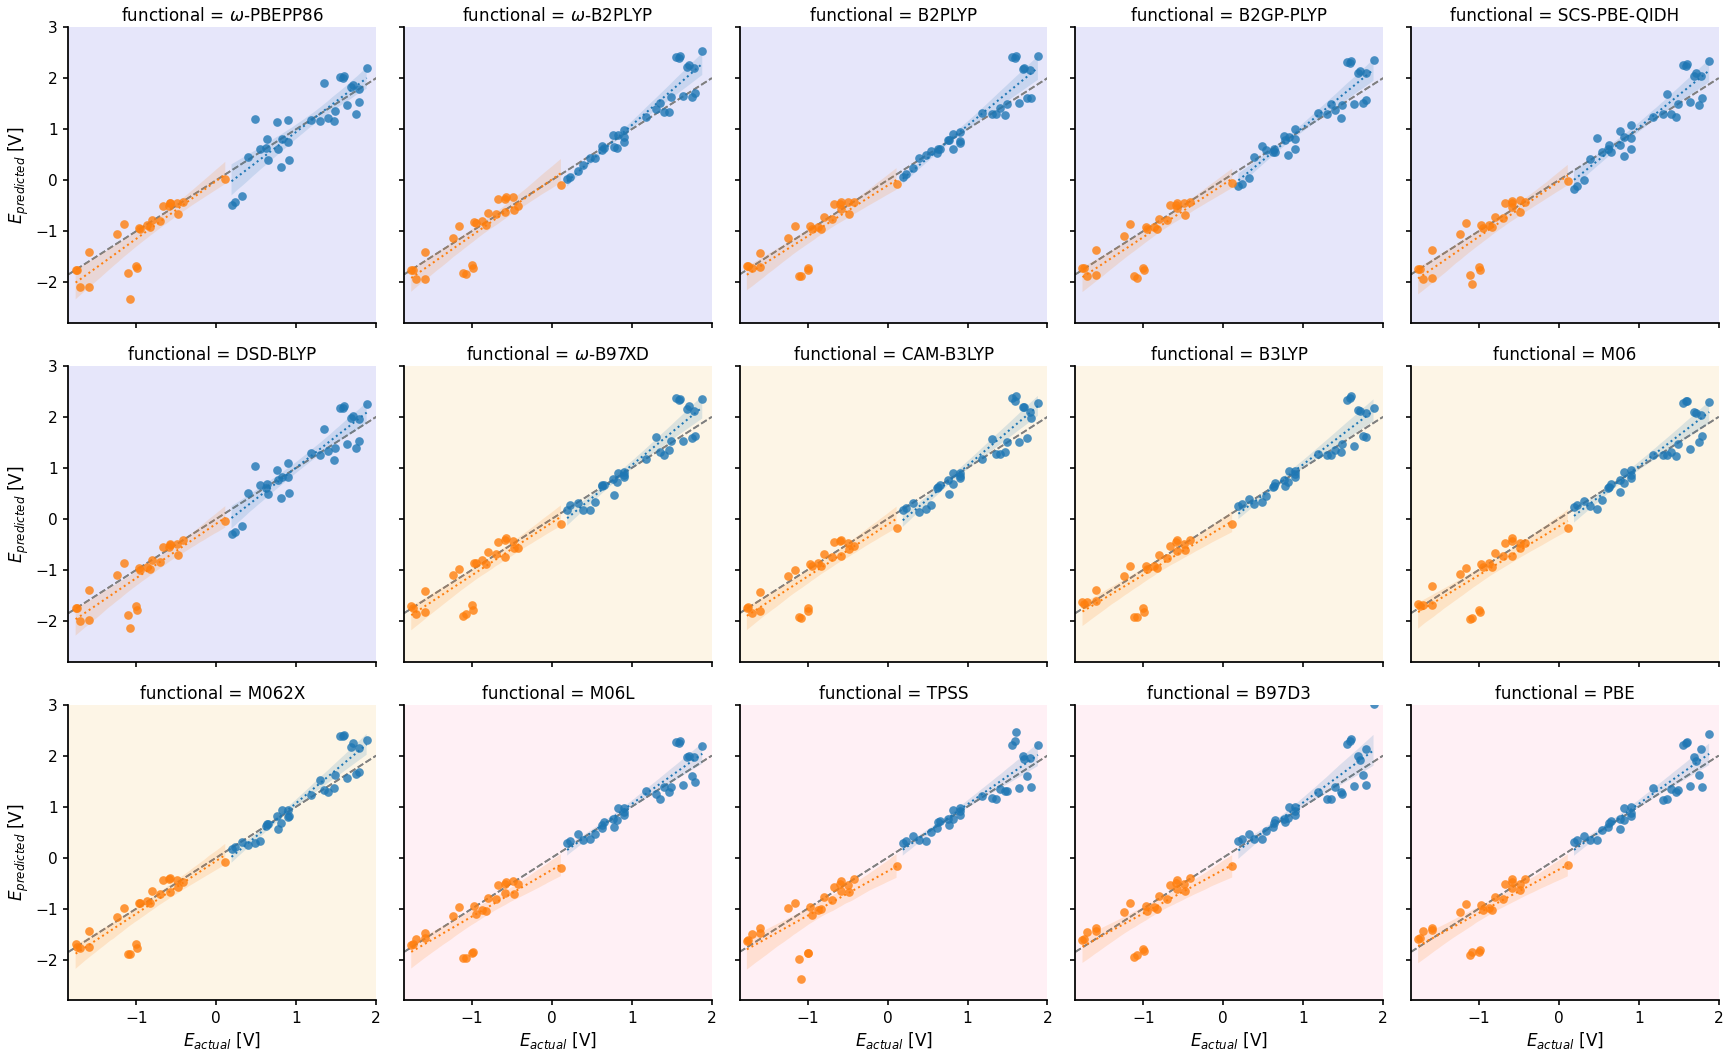

In [26]:
sns.reset_orig()
plt.style.use("seaborn-paper")
sns.set_context("paper", font_scale=1.75, rc={"lines.linewidth": 1.75,"axes.linewidth": 1.75,'xtick.major.width': 1.6,'ytick.major.width': 1.6})

# store underlying facet grid
g = sns.lmplot(x="actual_value", y="modified_value", col='functional', hue='potential_type', 
               col_wrap=5, data=gs_NoLimitShift, aspect=0.9, 
               scatter_kws={"s": 75}, line_kws={"lw": 2,"ls": ":"})

g.map_dataframe(lambda data, **kws: plt.axline((0,0), slope=1., c="grey", ls='--', zorder=0)) # x=y line, this requires the latest version of matplotlib
g.set(xlabel=(r'$E_{actual}$ [V]'),ylabel=(r'$E_{predicted}$ [V]'))
g._legend.remove()

for N, i in enumerate(g.axes.flat):
  if N < 6: # double hybrids
    i.set_facecolor("lavender")
  if N >= 6 and N < 11: # hybrids
    i.set_facecolor("oldlace")
  if N >= 11: # pure functionals
    i.set_facecolor("lavenderblush") # mistyrose

sns.despine()
plt.xlim(-1.85,2.0)
plt.ylim(-2.8,3.)
plt.tight_layout()
# plt.savefig('gs_redox_NoLimitShift.png', dpi=200, bbox_inches='tight', pad_inches=0)
plt.show()
plt.close()

In [27]:
# generate the text on the right side of the following plots

oxPotShiftList_ = NoLimitShift_params.query("potential_type == 'E(M+/M)'")["shift"].apply("{:.02f}".format).to_list()
redPotShiftList_ = NoLimitShift_params.query("potential_type == 'E(M/M-)'")["shift"].apply("{:.02f}".format).to_list()

plotstring2 = ""
for i, potshift in enumerate(oxPotShiftList_):
  plotstring2 += potshift + ' ' + redPotShiftList_[i] + '\n'

plotstring2_ox = ""
for i in oxPotShiftList_:
  if float(i) >= 0: # add a leading space to positive values to align them with the negatives
    i = " " + i
  plotstring2_ox += i + '\n'
plotstring2_ox = plotstring2_ox[:-1]

plotstring2_red = ""
for i in redPotShiftList_:
  plotstring2_red += i + '\n'
plotstring2_red = plotstring2_red[:-1]

<ipython-input-28-961f86e40e29>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-paper")


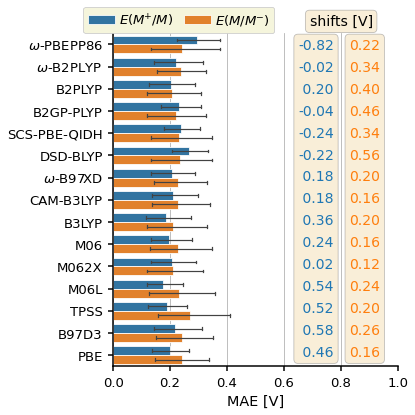

In [28]:
sns.reset_orig()
plt.style.use("seaborn-paper")
scale=1.5
sns.set_context("paper", font_scale=scale, rc={"lines.linewidth": scale,"axes.linewidth": 
                                               scale,'xtick.major.width': scale,'ytick.major.width': scale})

plt.figure(figsize=(6,6))
ax = sns.barplot(data=gs_NoLimitShift.replace({"E(M+/M)":r'$E(M\! ^+\! / M)$', "E(M/M-)":r'$E(M/ M\! ^-\!)$'}), 
                 x="modified_delta", y="functional", hue="potential_type", edgecolor="white", errwidth=1.2, capsize=.125)
ax.set(xlabel=r'MAE [V]', ylabel=None)
ax.grid(axis = 'x')
ax.set_axisbelow(True)

props = dict(boxstyle='round', facecolor='wheat', edgecolor='grey', alpha=0.5)
ax.text(0.65, 0.985, plotstring2_ox, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props, c=sns.color_palette()[0], linespacing=1.72)
ax.text(0.83, 0.985, plotstring2_red, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props, c=sns.color_palette()[1], linespacing=1.72)
ax.text(0.6905, 1.057, "shifts [V]", transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props, c='black', linespacing=1.72)

ax.legend(frameon=True, title=None, loc='center', facecolor="beige", framealpha=1, bbox_to_anchor=(0.23, 1.04), 
          ncols=2, columnspacing=0.85, handletextpad=0.3)

sns.despine()
plt.xlim(0,1.)
plt.tight_layout()
# plt.savefig('gs_redox_MAE_NoLimitShift_withtext.png', dpi=200, bbox_inches='tight', pad_inches=0.05)
plt.show()
plt.close()

<ipython-input-29-fd283bccd515>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-paper")


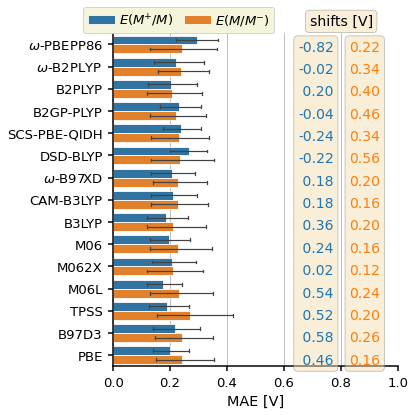

In [29]:
sns.reset_orig()
plt.style.use("seaborn-paper")
scale=1.5
sns.set_context("paper", font_scale=scale, rc={"lines.linewidth": scale,"axes.linewidth": 
                                               scale,'xtick.major.width': scale,'ytick.major.width': scale})

plt.figure(figsize=(6,6))
ax = sns.barplot(data=gs_NoLimitShift.replace({"E(M+/M)":r'$E(M\! ^+\! / M)$', "E(M/M-)":r'$E(M/ M\! ^-\!)$'}), 
                 x="modified_delta", y="functional", hue="potential_type", edgecolor="white", errwidth=1.2, capsize=.125)
ax.set(xlabel=r'MAE [V]', ylabel=None)
ax.grid(axis = 'x')
ax.set_axisbelow(True)

# text boxes appear at different locations on the saved image
props = dict(boxstyle='round', facecolor='wheat', edgecolor='grey', alpha=0.5)
ax.text(0.6495, 0.98, plotstring2_ox, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props, c=sns.color_palette()[0], linespacing=1.76)
ax.text(0.83, 0.98, plotstring2_red, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props, c=sns.color_palette()[1], linespacing=1.76)
ax.text(0.6905, 1.057, "shifts [V]", transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props, c='black')

ax.legend(frameon=True, title=None, loc='center', facecolor="beige", framealpha=1, bbox_to_anchor=(0.23, 1.04), 
          ncols=2, columnspacing=0.85, handletextpad=0.3)

sns.despine()
plt.xlim(0,1.)
plt.tight_layout()
# plt.savefig('gs_redox_MAE_NoLimitShift_withtext_.png', dpi=200, bbox_inches='tight', pad_inches=0.05)
plt.show()
plt.close()

In [30]:
totavg = gs_NoLimitShift["modified_delta"].mean().round(2)
totsem = gs_NoLimitShift["modified_delta"].sem().round(2)
print(f"Total average after shift: {totavg} (±{totsem}) V")

Total average after shift: 0.22 (±0.01) V


Optimize both scaling and shift parameters:

In [31]:
%%time
scales = np.linspace(0.8,1.1,11)
shifts = np.linspace(-0.5,0.5,51)
gs_OptShift_outliersOFF, opt_params_outliersOFF = optimize_predictions_no_outliers(longpots_to_plot, scales, shifts)

optimal scale and shift for $\omega$-PBEPP86 and E(M+/M): 0.8, -0.38
optimal scale and shift for $\omega$-PBEPP86 and E(M/M-): 0.8, 0.0
optimal scale and shift for $\omega$-B2PLYP and E(M+/M): 0.8, 0.16000000000000003
optimal scale and shift for $\omega$-B2PLYP and E(M/M-): 0.8, 0.040000000000000036
optimal scale and shift for B2PLYP and E(M+/M): 0.8, 0.30000000000000004
optimal scale and shift for B2PLYP and E(M/M-): 0.9500000000000001, 0.30000000000000004
optimal scale and shift for B2GP-PLYP and E(M+/M): 0.8, 0.16000000000000003
optimal scale and shift for B2GP-PLYP and E(M/M-): 0.8600000000000001, 0.28
optimal scale and shift for SCS-PBE-QIDH and E(M+/M): 0.8, 0.020000000000000018
optimal scale and shift for SCS-PBE-QIDH and E(M/M-): 0.8, 0.09999999999999998
optimal scale and shift for DSD-BLYP and E(M+/M): 0.8, 0.020000000000000018
optimal scale and shift for DSD-BLYP and E(M/M-): 0.8, 0.32000000000000006
optimal scale and shift for $\omega$-B97XD and E(M+/M): 0.8, 0.3399999999999

<ipython-input-32-da42e0283b94>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-paper")


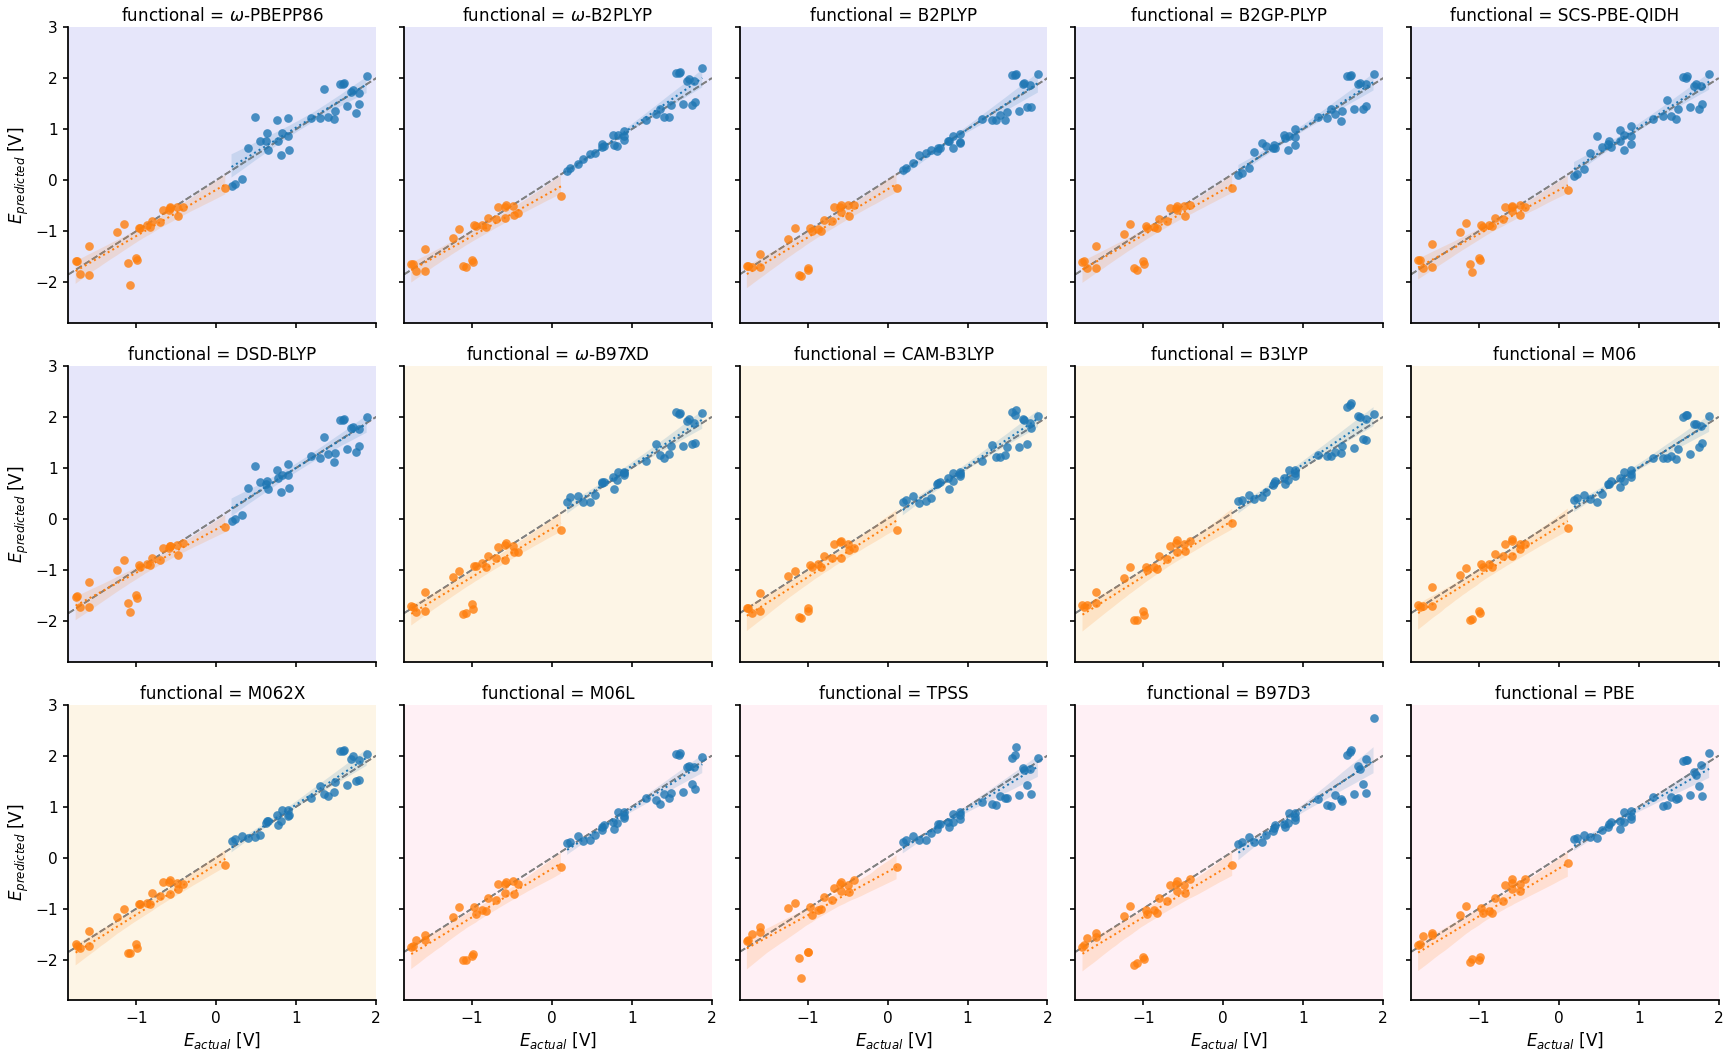

In [32]:
sns.reset_orig()
plt.style.use("seaborn-paper")
sns.set_context("paper", font_scale=1.75, rc={"lines.linewidth": 1.75,"axes.linewidth": 1.75,'xtick.major.width': 1.6,'ytick.major.width': 1.6})

# store underlying facet grid
g = sns.lmplot(x="actual_value", y="modified_value", col='functional', hue='potential_type', 
               col_wrap=5, data=gs_OptShift_outliersOFF, aspect=0.9, 
               scatter_kws={"s": 75}, line_kws={"lw": 2,"ls": ":"})

g.map_dataframe(lambda data, **kws: plt.axline((0,0), slope=1., c="grey", ls='--', zorder=0)) # x=y line, this requires the latest version of matplotlib
g.set(xlabel=(r'$E_{actual}$ [V]'),ylabel=(r'$E_{predicted}$ [V]'))
g._legend.remove()

for N, i in enumerate(g.axes.flat):
  if N < 6: # double hybrids
    i.set_facecolor("lavender")
  if N >= 6 and N < 11: # hybrids
    i.set_facecolor("oldlace")
  if N >= 11: # pure functionals
    i.set_facecolor("lavenderblush") # mistyrose

sns.despine()
plt.xlim(-1.85,2.0)
plt.ylim(-2.8,3.)
plt.tight_layout()
# plt.savefig('gs_redox_OptShiftScaled_outliersOFF.png', dpi=200, bbox_inches='tight', pad_inches=0)
plt.show()
plt.close()

<ipython-input-33-286a4db99e3c>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-paper")


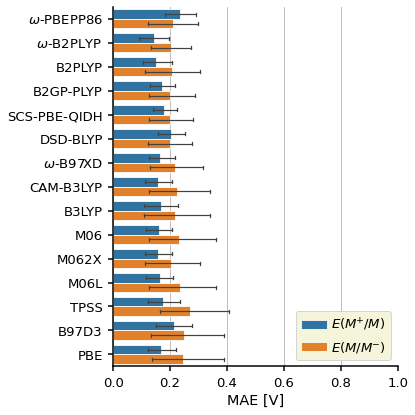

In [33]:
sns.reset_orig()
plt.style.use("seaborn-paper")
scale=1.5
sns.set_context("paper", font_scale=scale, rc={"lines.linewidth": scale,"axes.linewidth": 
                                               scale,'xtick.major.width': scale,'ytick.major.width': scale})

plt.figure(figsize=(6,6))
ax = sns.barplot(data=gs_OptShift_outliersOFF.replace({"E(M+/M)":r'$E(M\! ^+\! / M)$', "E(M/M-)":r'$E(M/ M\! ^-\!)$'}), 
                 x="modified_delta", y="functional", hue="potential_type", edgecolor="white", errwidth=1.2, capsize=.125)
ax.set(xlabel=r'MAE [V]', ylabel=None)
ax.legend(frameon=True, title=None, loc='lower right', facecolor="beige", framealpha=1, #bbox_to_anchor=(0.5, 1.04), 
          ncols=1, handletextpad=0.3)

ax.grid(axis = 'x')
ax.set_axisbelow(True)
sns.despine()
plt.xlim(0,1.)
plt.tight_layout()
# plt.savefig('gs_redox_OptShiftScaled_outliersOFF_MAE.png', dpi=200, bbox_inches='tight', pad_inches=0.05)
plt.show()
plt.close()

Plot the MAEs of some constant shifts:

In [34]:
longplots_multishift = longpots_to_plot.copy()
longplots_multishift["0.00 V"] = longplots_multishift["predicted_value"]
longplots_multishift["0.05 V"] = longplots_multishift["predicted_value"] + 0.05
longplots_multishift["0.10 V"] = longplots_multishift["predicted_value"] + 0.1
longplots_multishift["0.15 V"] = longplots_multishift["predicted_value"] + 0.15
longplots_multishift["0.20 V"] = longplots_multishift["predicted_value"] + 0.2
longplots_multishift["0.25 V"] = longplots_multishift["predicted_value"] + 0.25
longplots_multishift["0.30 V"] = longplots_multishift["predicted_value"] + 0.3
longplots_multishift["0.35 V"] = longplots_multishift["predicted_value"] + 0.35
longplots_multishift["0.40 V"] = longplots_multishift["predicted_value"] + 0.4

# longplots_multishift.drop(columns=["predicted_value","delta"], inplace=True)
longplots_multishift.drop(columns=["predicted_value","delta","solvent"], inplace=True)
longplots_multishift_long = pd.melt(longplots_multishift, 
                                   id_vars=longplots_multishift.columns[:4],
                                   value_vars=longplots_multishift.columns[4:],
                                   var_name="shift",
                                   value_name="predicted_value")

longplots_multishift_long["delta"] = abs(longplots_multishift_long["predicted_value"] - longplots_multishift_long["actual_value"])

longplots_multishift_long.query("molecule == 'BF3-Acr_m' and functional == 'M06' and potential_type == 'E(M+/M)'")

,molecule,functional,potential_type,actual_value,shift,predicted_value,delta
567,BF3-Acr_m,M06,E(M+/M),1.69,0.00 V,1.850794,0.160794
1422,BF3-Acr_m,M06,E(M+/M),1.69,0.05 V,1.900794,0.210794
2277,BF3-Acr_m,M06,E(M+/M),1.69,0.10 V,1.950794,0.260794
3132,BF3-Acr_m,M06,E(M+/M),1.69,0.15 V,2.000794,0.310794
3987,BF3-Acr_m,M06,E(M+/M),1.69,0.20 V,2.050794,0.360794
4842,BF3-Acr_m,M06,E(M+/M),1.69,0.25 V,2.100794,0.410794
5697,BF3-Acr_m,M06,E(M+/M),1.69,0.30 V,2.150794,0.460794
6552,BF3-Acr_m,M06,E(M+/M),1.69,0.35 V,2.200794,0.510794
7407,BF3-Acr_m,M06,E(M+/M),1.69,0.40 V,2.250794,0.560794


Calculate the overall MAEs for each shift value:

In [35]:
hybrid_functs = ["B3LYP", "M062X", "M06", "CAM-B3LYP", r'$\omega$-B97XD'] # r'$\\omega$-B97XD' will not include the functional; r'$\omega$-B97XD' must be used here

all_deltas_mean = longplots_multishift_long.drop(columns=["actual_value","predicted_value"]).groupby("shift", as_index=False).mean().rename(columns={"delta":"all_deltas_mean"})
all_deltas_sem = longplots_multishift_long.drop(columns=["actual_value","predicted_value"]).groupby("shift", as_index=False).sem().rename(columns={"delta":"all_deltas_sem"})
all_delta = all_deltas_mean.merge(all_deltas_sem)
hybrid_deltas_mean = longplots_multishift_long.query("functional in @hybrid_functs").drop(columns=["actual_value","predicted_value"]).groupby("shift", as_index=False).mean().rename(columns={"delta":"hybrid_deltas_mean"})
hybrid_deltas_sem = longplots_multishift_long.query("functional in @hybrid_functs").drop(columns=["actual_value","predicted_value"]).groupby("shift", as_index=False).sem().rename(columns={"delta":"hybrid_deltas_sem"})
hybrid_delta = hybrid_deltas_mean.merge(hybrid_deltas_sem)

all_delta['delta_all'] = all_delta['all_deltas_mean'].apply("{:.03f}".format) + ' (±' + all_delta["all_deltas_sem"].apply("{:.03f}".format) + ')'
hybrid_delta['delta_hybrid'] = hybrid_delta['hybrid_deltas_mean'].apply("{:.03f}".format) + ' (±' + hybrid_delta["hybrid_deltas_sem"].apply("{:.03f}".format) + ')'
merged_delta = all_delta.merge(hybrid_delta).get(["shift","delta_all","delta_hybrid"])

# merged_delta.to_csv("shift_mse_deltas.csv", index=False) # uncomment to save to file
merged_delta

,shift,delta_all,delta_hybrid
0,0.00 V,0.382 (±0.010),0.287 (±0.015)
1,0.05 V,0.358 (±0.010),0.261 (±0.014)
2,0.10 V,0.339 (±0.010),0.242 (±0.014)
3,0.15 V,0.326 (±0.010),0.229 (±0.014)
4,0.20 V,0.320 (±0.011),0.227 (±0.014)
5,0.25 V,0.321 (±0.011),0.237 (±0.014)
6,0.30 V,0.328 (±0.011),0.253 (±0.014)
7,0.35 V,0.341 (±0.011),0.278 (±0.014)
8,0.40 V,0.360 (±0.011),0.308 (±0.014)


- hybrid functionals are better than average
- best delta for all functionals: 0.20 V
- best delta for the hybrids: 0.20 V

<ipython-input-36-b69973887fd2>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-paper")


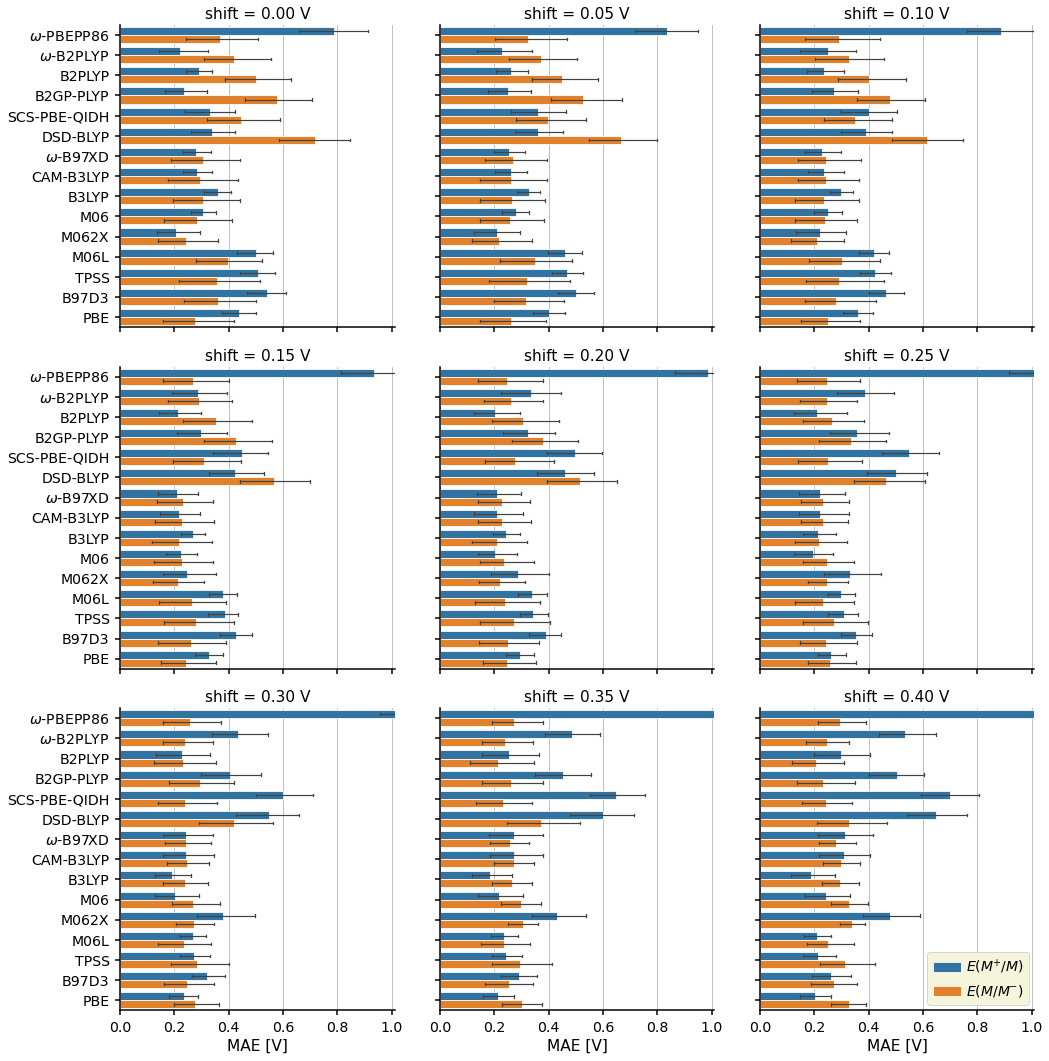

In [36]:
sns.reset_orig()
plt.style.use("seaborn-paper")
scale=1.5
sns.set_context("paper", font_scale=1.6, rc={"lines.linewidth": scale,"axes.linewidth": 
                                               scale,'xtick.major.width': scale,'ytick.major.width': scale})

g = sns.FacetGrid(longplots_multishift_long.replace({"E(M+/M)":r'$E(M\! ^+\! / M)$', "E(M/M-)":r'$E(M/ M\! ^-\!)$'}), 
                  col="shift", col_wrap=3, height=5, aspect=0.9)
g.map_dataframe(sns.barplot, x="delta", y="functional", hue="potential_type",
                edgecolor="white", errwidth=1.2, capsize=.125, palette=sns.color_palette())
g.set(xlabel=r'MAE [V]', ylabel=None)
g.add_legend(frameon=True, title=None, loc='center', facecolor="beige", framealpha=1, ncol=1, bbox_to_anchor=(0.92, 0.085), fontsize=14, handletextpad=0.35)

# ax.set(xlabel=r'MAE [V]', ylabel=None)
# ax.legend(frameon=True, title=None, loc='center', facecolor="white", framealpha=1, ncol=2, bbox_to_anchor=(0.5, 1.04))
# ax.grid(axis = 'x')
# ax.set_axisbelow(True)
for ax in g.axes.flat:
  ax.grid(True, axis='x')
  ax.set_axisbelow(True)
sns.despine()
plt.xlim(0,1.01)
plt.tight_layout()
# plt.savefig(f'constant_shifts_MAE.png', dpi=200, bbox_inches='tight', pad_inches=0.05)
plt.show()
plt.close()

## Solvation energies

In [38]:
b2plyp_solvfile = "/content/DFT-ML-excited-state-redox/redox_E_solv_B2PLYP.csv"
wb2plyp_solvfile = "/content/DFT-ML-excited-state-redox/redox_E_solv_wB2PLYP.csv"
dsdblyp_solvfile = "/content/DFT-ML-excited-state-redox/redox_E_solv_DSD-BLYP.csv"

def gen_solvdata(solvfile, functional, full_db):
  solvdata_raw = pd.read_csv(solvfile)
  if functional == "wB2PLYP":
    functional = "$\omega$-B2PLYP"
  solvdata = full_db.query("functional == @functional").copy()
  solvdata["dGr_ox"] = -23.061*(solvdata["E(M+/M)"] + 4.522) # 4.522 eV = 104.28 kcal/mol
  solvdata["dGr_red"] = -23.061*(solvdata["E(M/M-)"] + 4.522) # 4.522 eV = 104.28 kcal/mol
  solvdata = solvdata.merge(solvdata_raw)
  solvdata["dEr_ox"] = solvdata["dGr_ox"] - solvdata["dE_ox"]
  solvdata["dEr_red"] = solvdata["dGr_red"] - solvdata["dE_red"]
  solvdata["dE_ox"] = abs(solvdata["dE_ox"])
  solvdata["dE_red"] = abs(solvdata["dE_red"])
  return solvdata

b2plyp_data = gen_solvdata(b2plyp_solvfile, "B2PLYP", gs_redox_potentials)
wb2plyp_data = gen_solvdata(wb2plyp_solvfile, "wB2PLYP", gs_redox_potentials) # works with both wB2PLYP and $\omega$-B2PLYP
dsdblyp_data = gen_solvdata(dsdblyp_solvfile, "DSD-BLYP", gs_redox_potentials)


In [39]:
b2plyp_data.get(["neutral_charge","E_solv_neutral"]).groupby("neutral_charge", as_index=False).mean()

,neutral_charge,E_solv_neutral
0,-2,-141.290000
1,0,-27.325000
2,1,-52.302857


<ipython-input-40-af145ec8dbbc>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-paper")


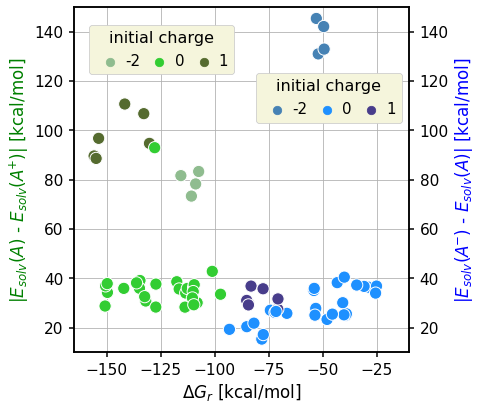

In [40]:
sns.reset_orig()
plt.style.use("seaborn-paper")
scale=1.5
sns.set_context("paper", font_scale=1.75, rc={"lines.linewidth": scale,"axes.linewidth": 
                                               scale,'xtick.major.width': scale,'ytick.major.width': scale})

# greens = ["#90ee90","#228c22","#004225"]
greens = ["darkseagreen","limegreen","darkolivegreen"]
# blues = ["#52b2bf","#4666ff","#051094"]
blues = ["steelblue","dodgerblue","darkslateblue"]
fig, ax = plt.subplots(figsize=(7,6))


sns.scatterplot(ax=ax, data=b2plyp_data, x="dGr_ox", y="dE_ox", hue="neutral_charge", s=150, palette=greens)
ax2 = ax.twinx()
sns.scatterplot(ax=ax2, data=b2plyp_data, x="dGr_red", y="dE_red", hue="neutral_charge", s=150, palette=blues)
ax.set_xlabel(r"$-23.061 \times (E + 4.522)$ [kcal/mol]")
ax.set_xlabel(r"$\Delta G_r$ [kcal/mol]")
ax.set_ylabel(r"$|E_{solv} (A)$ - $E_{solv} (A \! ^+ \!)|$ [kcal/mol]", color='g')
ax.set_ylim(10,150)
ax.set_xlim(-160,0)
ax.get_legend().remove()
# ax.legend(frameon=True, title="initial charge", loc='upper right', facecolor="white", framealpha=1, bbox_to_anchor=(1., 1.011), 
#           ncols=3, columnspacing=0.3, fontsize=15, title_fontsize=16, handletextpad=0.01)
ax.legend(frameon=True, title="initial charge", loc='upper right', facecolor="beige", framealpha=1, bbox_to_anchor=(0.5, 0.97), 
          ncols=3, columnspacing=0.3, fontsize=15, title_fontsize=16, handletextpad=0.01, markerscale=1.75)
ax.set_axisbelow(True)
ax.grid(None)
ax2.set_ylabel(r"$|E_{solv} (A \! ^- \!)$ - $E_{solv} (A)|$ [kcal/mol]", color='b')
ax2.set_ylim(10,150)
ax2.set_xlim(-165,-10)
ax2.get_legend().remove()
# ax2.legend(frameon=True, title="initial charge", loc='upper right', facecolor="white", framealpha=1, bbox_to_anchor=(1., 0.844), 
#            ncols=3, columnspacing=0.3, fontsize=15, title_fontsize=16, handletextpad=0.01)
ax2.legend(frameon=True, title="initial charge", loc='upper right', facecolor="beige", framealpha=1, bbox_to_anchor=(1., 0.83), 
           ncols=3, columnspacing=0.3, fontsize=15, title_fontsize=16, handletextpad=0.01, markerscale=1.75)
ax2.set_axisbelow(True)
# ax2.grid(axis = 'x') # why does is still show both x and y gridlines?

plt.tight_layout()
# plt.savefig('solvation_levels_B2PLYP.png', dpi=200, bbox_inches='tight', pad_inches=0.05)
plt.show()
plt.close()

<ipython-input-41-66738b820f4a>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-paper")


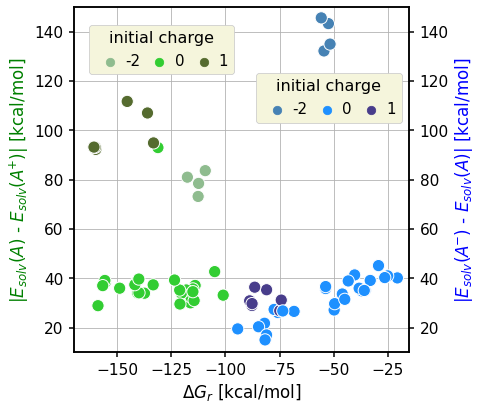

In [41]:
sns.reset_orig()
plt.style.use("seaborn-paper")
scale=1.5
sns.set_context("paper", font_scale=1.75, rc={"lines.linewidth": scale,"axes.linewidth": 
                                               scale,'xtick.major.width': scale,'ytick.major.width': scale})

# greens = ["#90ee90","#228c22","#004225"]
greens = ["darkseagreen","limegreen","darkolivegreen"]
# blues = ["#52b2bf","#4666ff","#051094"]
blues = ["steelblue","dodgerblue","darkslateblue"]
fig, ax = plt.subplots(figsize=(7,6))


sns.scatterplot(ax=ax, data=wb2plyp_data, x="dGr_ox", y="dE_ox", hue="neutral_charge", s=150, palette=greens)
ax2 = ax.twinx()
sns.scatterplot(ax=ax2, data=wb2plyp_data, x="dGr_red", y="dE_red", hue="neutral_charge", s=150, palette=blues)
ax.set_xlabel(r"$-23.061 \times (E + 4.522)$ [kcal/mol]")
ax.set_xlabel(r"$\Delta G_r$ [kcal/mol]")
ax.set_ylabel(r"$|E_{solv} (A)$ - $E_{solv} (A \! ^+ \!)|$ [kcal/mol]", color='g')
ax.set_ylim(10,150)
ax.set_xlim(-160,0)
ax.get_legend().remove()
# ax.legend(frameon=True, title="initial charge", loc='upper right', facecolor="white", framealpha=1, bbox_to_anchor=(1., 1.011), 
#           ncols=3, columnspacing=0.3, fontsize=15, title_fontsize=16, handletextpad=0.01)
ax.legend(frameon=True, title="initial charge", loc='upper right', facecolor="beige", framealpha=1, bbox_to_anchor=(0.5, 0.97), 
          ncols=3, columnspacing=0.3, fontsize=15, title_fontsize=16, handletextpad=0.01, markerscale=1.75)
ax.set_axisbelow(True)
ax.grid(None)
ax2.set_ylabel(r"$|E_{solv} (A \! ^- \!)$ - $E_{solv} (A)|$ [kcal/mol]", color='b')
ax2.set_ylim(10,150)
ax2.set_xlim(-170,-15)
ax2.get_legend().remove()
# ax2.legend(frameon=True, title="initial charge", loc='upper right', facecolor="white", framealpha=1, bbox_to_anchor=(1., 0.844), 
#            ncols=3, columnspacing=0.3, fontsize=15, title_fontsize=16, handletextpad=0.01)
ax2.legend(frameon=True, title="initial charge", loc='upper right', facecolor="beige", framealpha=1, bbox_to_anchor=(1., 0.83), 
           ncols=3, columnspacing=0.3, fontsize=15, title_fontsize=16, handletextpad=0.01, markerscale=1.75)
ax2.set_axisbelow(True)
# ax2.grid(axis = 'x') # why does is still show both x and y gridlines?

plt.tight_layout()
# plt.savefig('solvation_levels_wB2PLYP.png', dpi=200, bbox_inches='tight', pad_inches=0.05)
plt.show()
plt.close()

<ipython-input-42-6312cafe6935>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-paper")


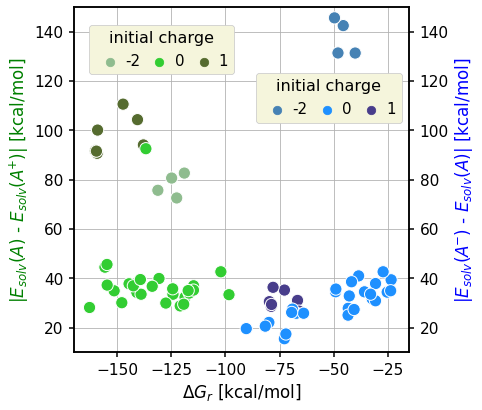

In [42]:
sns.reset_orig()
plt.style.use("seaborn-paper")
scale=1.5
sns.set_context("paper", font_scale=1.75, rc={"lines.linewidth": scale,"axes.linewidth": 
                                               scale,'xtick.major.width': scale,'ytick.major.width': scale})

# greens = ["#90ee90","#228c22","#004225"]
greens = ["darkseagreen","limegreen","darkolivegreen"]
# blues = ["#52b2bf","#4666ff","#051094"]
blues = ["steelblue","dodgerblue","darkslateblue"]
fig, ax = plt.subplots(figsize=(7,6))


sns.scatterplot(ax=ax, data=dsdblyp_data, x="dGr_ox", y="dE_ox", hue="neutral_charge", s=150, palette=greens)
ax2 = ax.twinx()
sns.scatterplot(ax=ax2, data=dsdblyp_data, x="dGr_red", y="dE_red", hue="neutral_charge", s=150, palette=blues)
ax.set_xlabel(r"$-23.061 \times (E + 4.522)$ [kcal/mol]")
ax.set_xlabel(r"$\Delta G_r$ [kcal/mol]")
ax.set_ylabel(r"$|E_{solv} (A)$ - $E_{solv} (A \! ^+ \!)|$ [kcal/mol]", color='g')
ax.set_ylim(10,150)
ax.set_xlim(-165,-10)
ax.get_legend().remove()
# ax.legend(frameon=True, title="initial charge", loc='upper right', facecolor="white", framealpha=1, bbox_to_anchor=(1., 1.011), 
#           ncols=3, columnspacing=0.3, fontsize=15, title_fontsize=16, handletextpad=0.01)
ax.legend(frameon=True, title="initial charge", loc='upper right', facecolor="beige", framealpha=1, bbox_to_anchor=(0.5, 0.97), 
          ncols=3, columnspacing=0.3, fontsize=15, title_fontsize=16, handletextpad=0.01, markerscale=1.75)
ax.set_axisbelow(True)
ax.grid(None)
ax2.set_ylabel(r"$|E_{solv} (A \! ^- \!)$ - $E_{solv} (A)|$ [kcal/mol]", color='b')
ax2.set_ylim(10,150)
ax2.set_xlim(-170,-15)
ax2.get_legend().remove()
# ax2.legend(frameon=True, title="initial charge", loc='upper right', facecolor="white", framealpha=1, bbox_to_anchor=(1., 0.844), 
#            ncols=3, columnspacing=0.3, fontsize=15, title_fontsize=16, handletextpad=0.01)
ax2.legend(frameon=True, title="initial charge", loc='upper right', facecolor="beige", framealpha=1, bbox_to_anchor=(1., 0.83), 
           ncols=3, columnspacing=0.3, fontsize=15, title_fontsize=16, handletextpad=0.01, markerscale=1.75)
ax2.set_axisbelow(True)
# ax2.grid(axis = 'x') # why does is still show both x and y gridlines?

plt.tight_layout()
# plt.savefig('solvation_levels_DSD-BLYP.png', dpi=200, bbox_inches='tight', pad_inches=0.05)
plt.show()
plt.close()